In [1]:
import datetime
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import datetime
from common import Fonts, Images, Colors, add_twitter_handle

In [2]:
year = 2023

# Color constants
EDGE_COLOR = Colors.GRAY
GRID_COLOR = Colors.LIGHT_GRAY
colors = ["#CCE6E6", "#AAD5D5", "#66B4B4", "#44A3A3", "#229191", "#008080"]
my_cmap = matplotlib.colors.ListedColormap(colors, name="my_cmap")
# Only register once
matplotlib.colormaps.register(cmap=my_cmap)
COLORMAP = "my_cmap"
BAR_COLOR = Colors.GRAY
HIGHLIGHT_COLOR = colors[-1]
W = 11
H = 7
# Set up fonts for the whole chart once
matplotlib.font_manager.fontManager.addfont(Fonts.BARLOW.get_file())
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = Fonts.BARLOW.get_name()

In [3]:
# Read in the data and add date breakdown columns
df = pd.read_csv("data/" + str(year) + "_schedule.csv")
df["date"] = pd.to_datetime(df["date"])
df["time"] = pd.to_datetime(df["time"])
df["day_of_week"] = (df["date"].dt.dayofweek + 2) % 7
df["week_of_year"] = df["date"].dt.isocalendar().week
df

,date,time,home,away,is_challenge_cup,day_of_week,week_of_year
0,2023-04-19,2023-02-10 19:00:00,ORL,NC,True,4,16
1,2023-04-19,2023-02-10 19:30:00,NJY,WAS,True,4,16
2,2023-04-19,2023-02-10 19:00:00,HOU,KC,True,4,16
3,2023-04-19,2023-02-10 19:00:00,LA,RGN,True,4,16
4,2023-04-19,2023-02-10 19:00:00,SD,POR,True,4,16
...,...,...,...,...,...,...,...
163,2023-10-15,2023-02-10 17:00:00,NJY,KC,False,1,41
164,2023-10-15,2023-02-10 17:00:00,ORL,HOU,False,1,41
165,2023-10-15,2023-02-10 16:00:00,CHI,RGN,False,1,41
166,2023-10-15,2023-02-10 14:00:00,LA,POR,False,1,41


In [4]:
def create_axes():
    plt.clf()
    fig = plt.figure(dpi=200, figsize=(W, H), facecolor="white")
    fig.patch.set_facecolor(Colors.WHITE)

    # Heatmap
    ax0 = fig.add_axes([0, 0, 0.7, 0.26])
    # Week of year
    ax1 = fig.add_axes([0, 0.3, 0.7, 0.2])
    # Day of week
    ax2 = fig.add_axes([0.73, 0, 0.15, 0.26])
    # Title
    ax3 = fig.add_axes([0, 0.45, 0.5, 0.1])

    axes = [ax0, ax1, ax2, ax3]

    # Set defaults for axes
    for ax in axes:
        ax.set_facecolor(Colors.WHITE)
        
        ax.xaxis.set_tick_params(which="both", length=0)
        ax.yaxis.set_tick_params(which="both", length=0)

        for spine in ax.spines.values():
            spine.set_edgecolor(EDGE_COLOR)
            spine.set_visible(False)

        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(which="both", axis="y", ls="--", color=GRID_COLOR, linewidth=1)
        ax.set_axisbelow(True)
    return fig, axes


def number_format_axis(axis):
    """
    Set the provided axis to report shortened numbers in the thousands.
    """
    axis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: "0" if x == 0 else "{:,.0f}".format(x / 1000) + "K"
        )
    )


def get_dates_for_day(df, day):
    months = pd.DataFrame(
        map(
            lambda x: datetime.date(df["date"].min().year, x, day),
            range(df["date"].min().month, df["date"].max().month + 1),
        ),
        columns=["date"],
    )
    months["date"] = pd.to_datetime(months["date"])
    months["day_of_week"] = months["date"].dt.dayofweek
    months["week_of_year"] = months["date"].dt.isocalendar().week
    return months

<Figure size 432x288 with 0 Axes>

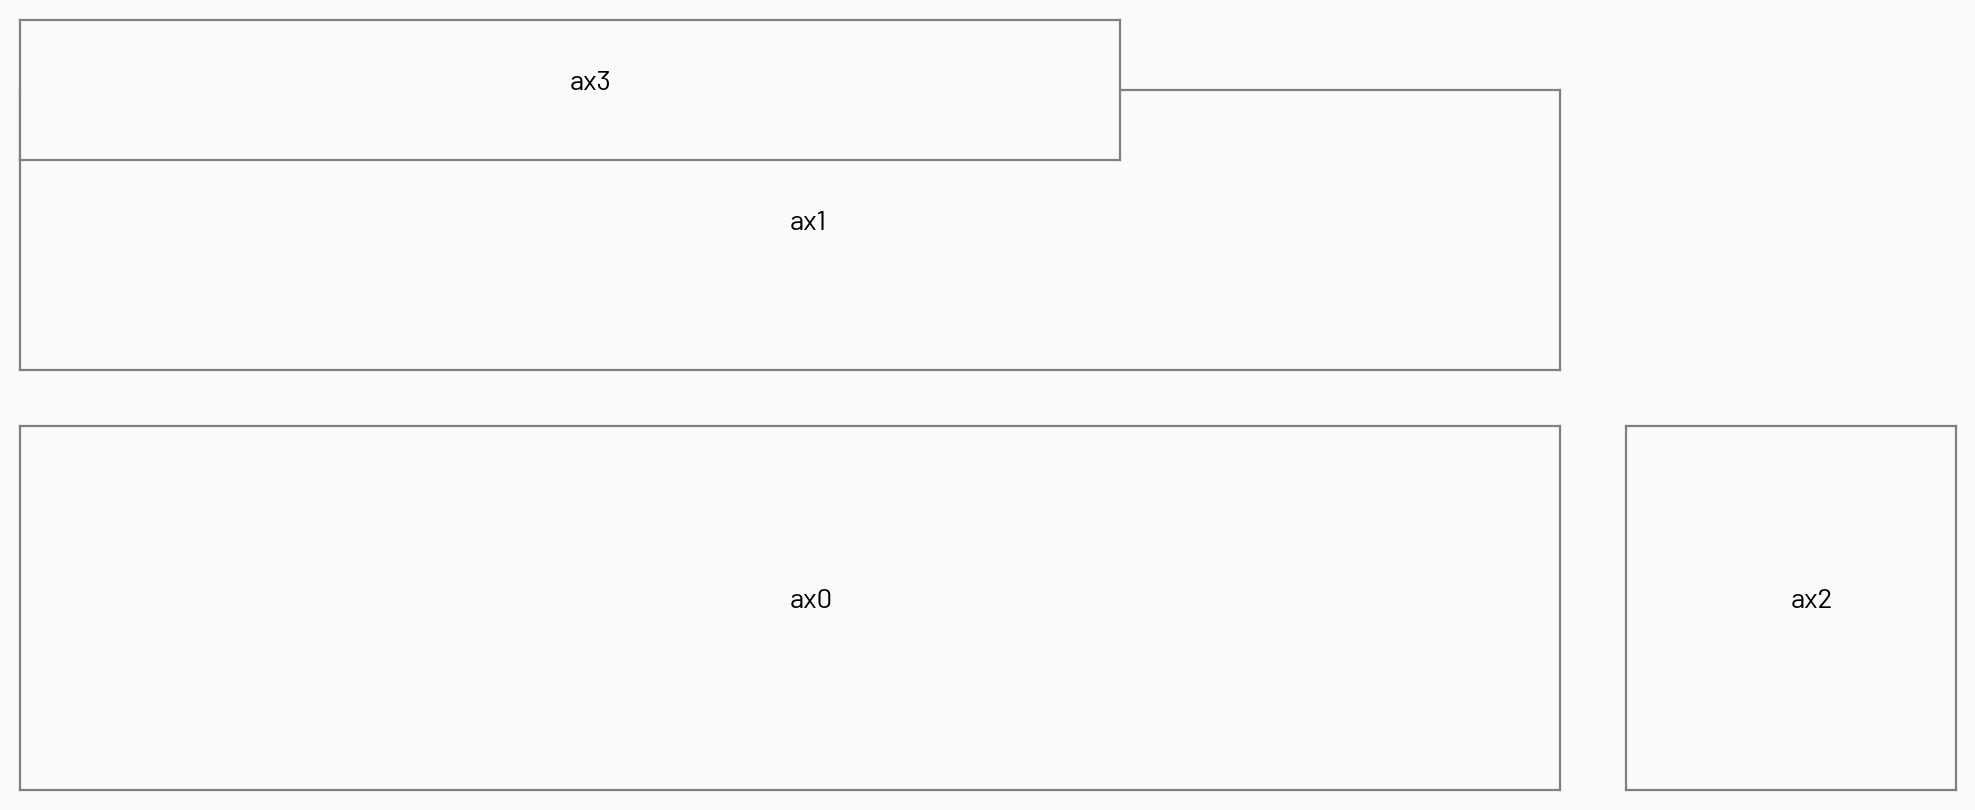

In [5]:
# Sample layout of axes
_, axes = create_axes()

for i, ax in enumerate(axes):
    ax.axis("on")
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.text(0.5, 0.5, "ax" + str(i))

<Figure size 432x288 with 0 Axes>

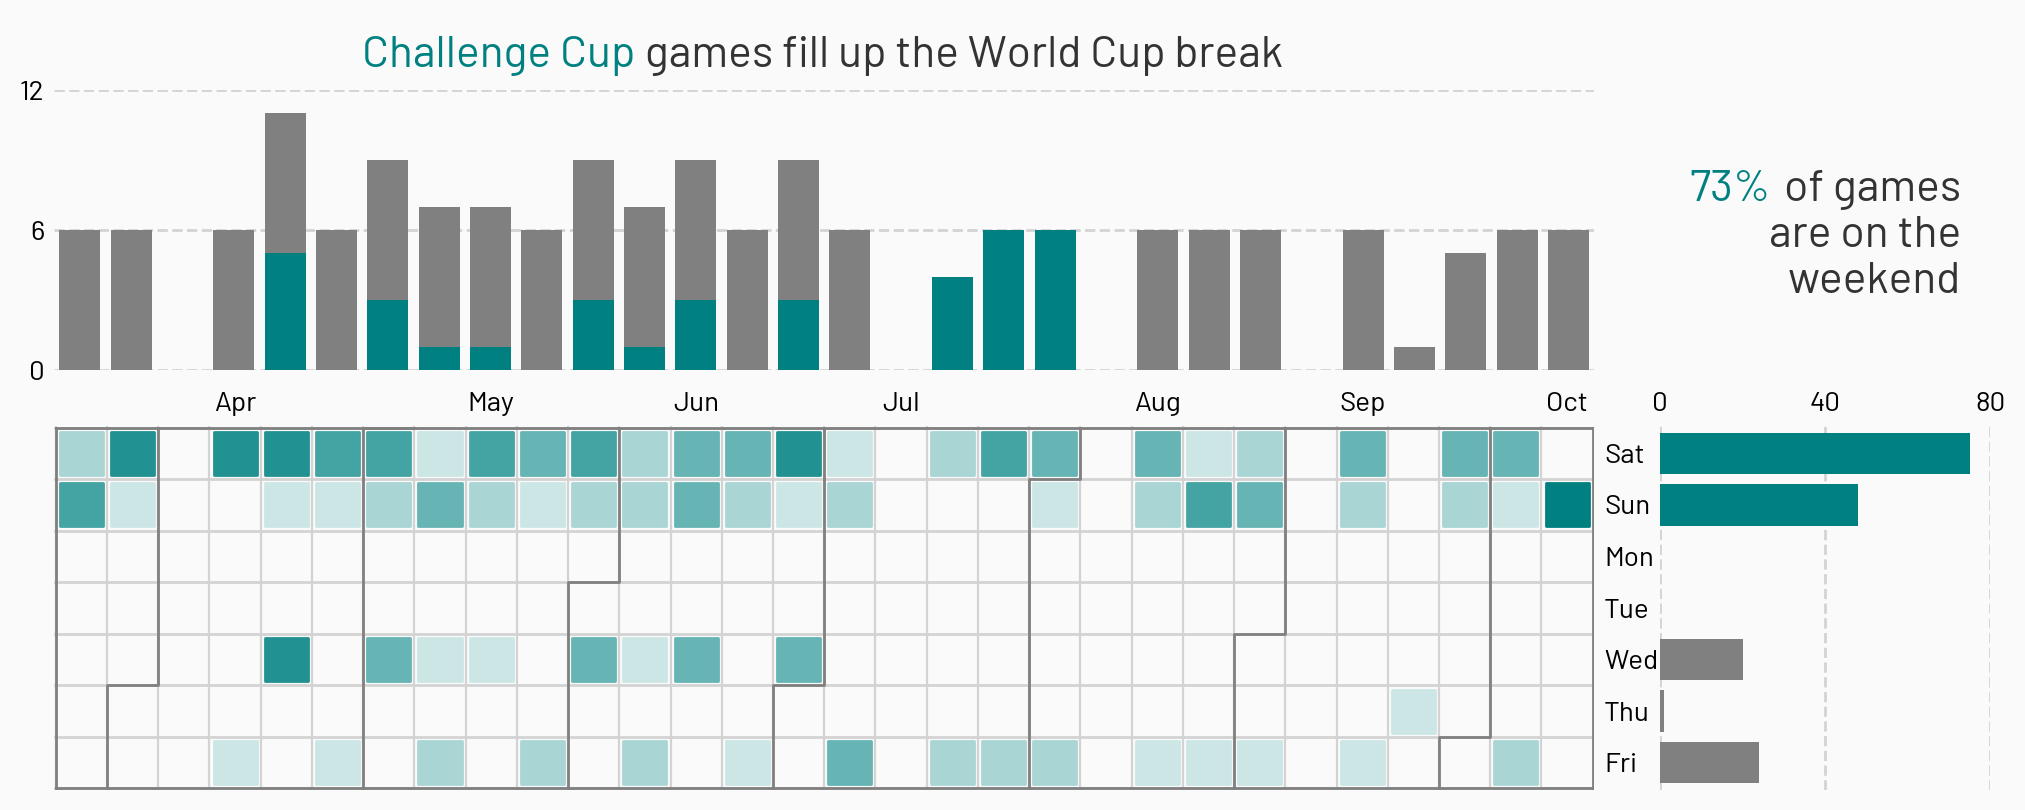

In [6]:
def draw_heatmap(ax0, ax1, ax2):
    # Generate data

    # Grouped data for heatmap
    df_group = (
        df.groupby(["day_of_week", "week_of_year"])
        .agg({"date": "count", "is_challenge_cup": "sum"})
        .reset_index()
        .rename(columns={"date": "count"})
    )
    # Calculate bounds
    xlim = [df_group["week_of_year"].min() - 0.5, df_group["week_of_year"].max() + 0.5]
    ylim = [-0.5, 6.5]
    # Calculate lines between months
    months = get_dates_for_day(df, 1)
    lines = []
    for i, row in months.iterrows():
        week = row["week_of_year"]
        y = [-0.5, row["day_of_week"] - 0.5, row["day_of_week"] - 0.5, 6.5]
        x = [week + 0.5, week + 0.5, week - 0.5, week - 0.5]
        lines.append((x, y))
    # Calculate outer borders
    lines.append(([xlim[0], xlim[1]], [ylim[0], ylim[0]]))
    lines.append(([xlim[0], xlim[1]], [ylim[1], ylim[1]]))
    lines.append(([xlim[0], xlim[0]], [ylim[0], ylim[1]]))
    lines.append(([xlim[1], xlim[1]], [ylim[0], ylim[1]]))
    # Calculate month labels
    month_labels = get_dates_for_day(df, 15)
    month_labels["month"] = month_labels["date"].dt.month_name().str[:3]

    # Plot data

    # Heatmap
    ax0.scatter(
        df_group["week_of_year"],
        df_group["day_of_week"],
        marker="s",
        s=240,
        c=df_group["count"],
        cmap=COLORMAP,
    )

    # Draw borders between months and on borders
    for (x, y) in lines:
        ax0.plot(x, y, color=EDGE_COLOR, linewidth=1)

    # Axis labels
    ax0.axis("on")
    ax0.set_yticks(range(0, 7))
    ax0.set_yticklabels(["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"])
    ax0.set_xticks(list(month_labels["week_of_year"]))
    ax0.set_xticklabels(list(month_labels["month"]))
    ax0.set_xlim([xlim[0] - 0.03, xlim[1] + 0.03])
    # Flip y axis
    ax0.set_ylim([ylim[1] + 0.03, ylim[0] - 0.03])
    ax0.tick_params(labeltop=True, labelbottom=False, labelright=True, labelleft=False)
    ax0.set_yticks(np.arange(-0.5, 7, 1), minor=True)
    ax0.set_xticks(np.arange(xlim[0], xlim[1], 1), minor=True)
    ax0.grid(color=GRID_COLOR, which="minor", linestyle="-")
    ax0.grid(False, which="major")

    # Day of week chart
    df_day_of_week = df_group.groupby("day_of_week").agg({"count": "sum"}).reset_index()
    ax2.barh(
        df_day_of_week["day_of_week"],
        df_day_of_week["count"],
        height=0.8,
        color=[
            HIGHLIGHT_COLOR,
            HIGHLIGHT_COLOR,
            BAR_COLOR,
            BAR_COLOR,
            BAR_COLOR,
            BAR_COLOR,
        ],
    )
    # Flip y axis
    ax2.set_ylim([ylim[1] + 0.03, ylim[0] - 0.03])
    ax2.axis("on")
    ax2.set_xticks([0, 40, 80])
    number_format_axis(ax2.yaxis)
    ax2.grid(which="both", axis="x", ls="--", color=GRID_COLOR, linewidth=1)
    ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Week of year chart
    df_week_of_year = (
        df_group.groupby("week_of_year")
        .agg({"count": "sum", "is_challenge_cup": "sum"})
        .reset_index()
    )
    # Split data into challenge cup and non-challenge cup games for a stacked
    # bar chart
    challenge = df_week_of_year.copy()
    challenge["count"] = challenge["is_challenge_cup"]
    non_challenge = df_week_of_year.copy()
    non_challenge["count"] = non_challenge["count"] - non_challenge["is_challenge_cup"]
    ax1.bar(
        challenge["week_of_year"],
        challenge["count"],
        width=0.8,
        color=HIGHLIGHT_COLOR,
    )
    ax1.bar(
        non_challenge["week_of_year"],
        non_challenge["count"],
        width=0.8,
        color=BAR_COLOR,
        bottom=challenge["count"],
    )
    ax1.set_xlim(xlim)
    ax1.axis("on")
    ax1.set_yticks([0, 6, 12])
    number_format_axis(ax1.xaxis)
    ax1.grid(which="both", axis="x", ls="--", color=GRID_COLOR, linewidth=1)

    # Contextual descriptions
    ax1.text(23, 13, "Challenge Cup ", fontsize=16, ha="right", color=HIGHLIGHT_COLOR)
    ax1.text(
        23, 13, "games fill up the World Cup break", fontsize=16, ha="left", color=Colors.BLACK
    )
    ax2.text(7, -5.5, "73%", fontsize=16, color=HIGHLIGHT_COLOR, va="top", ha="left")
    ax2.text(
        73,
        -5.5,
        "of games\nare on the\nweekend",
        fontsize=16,
        va="top",
        ha="right",
        color=Colors.BLACK,
    )


_, axes = create_axes()
draw_heatmap(axes[0], axes[1], axes[2])

<Figure size 432x288 with 0 Axes>

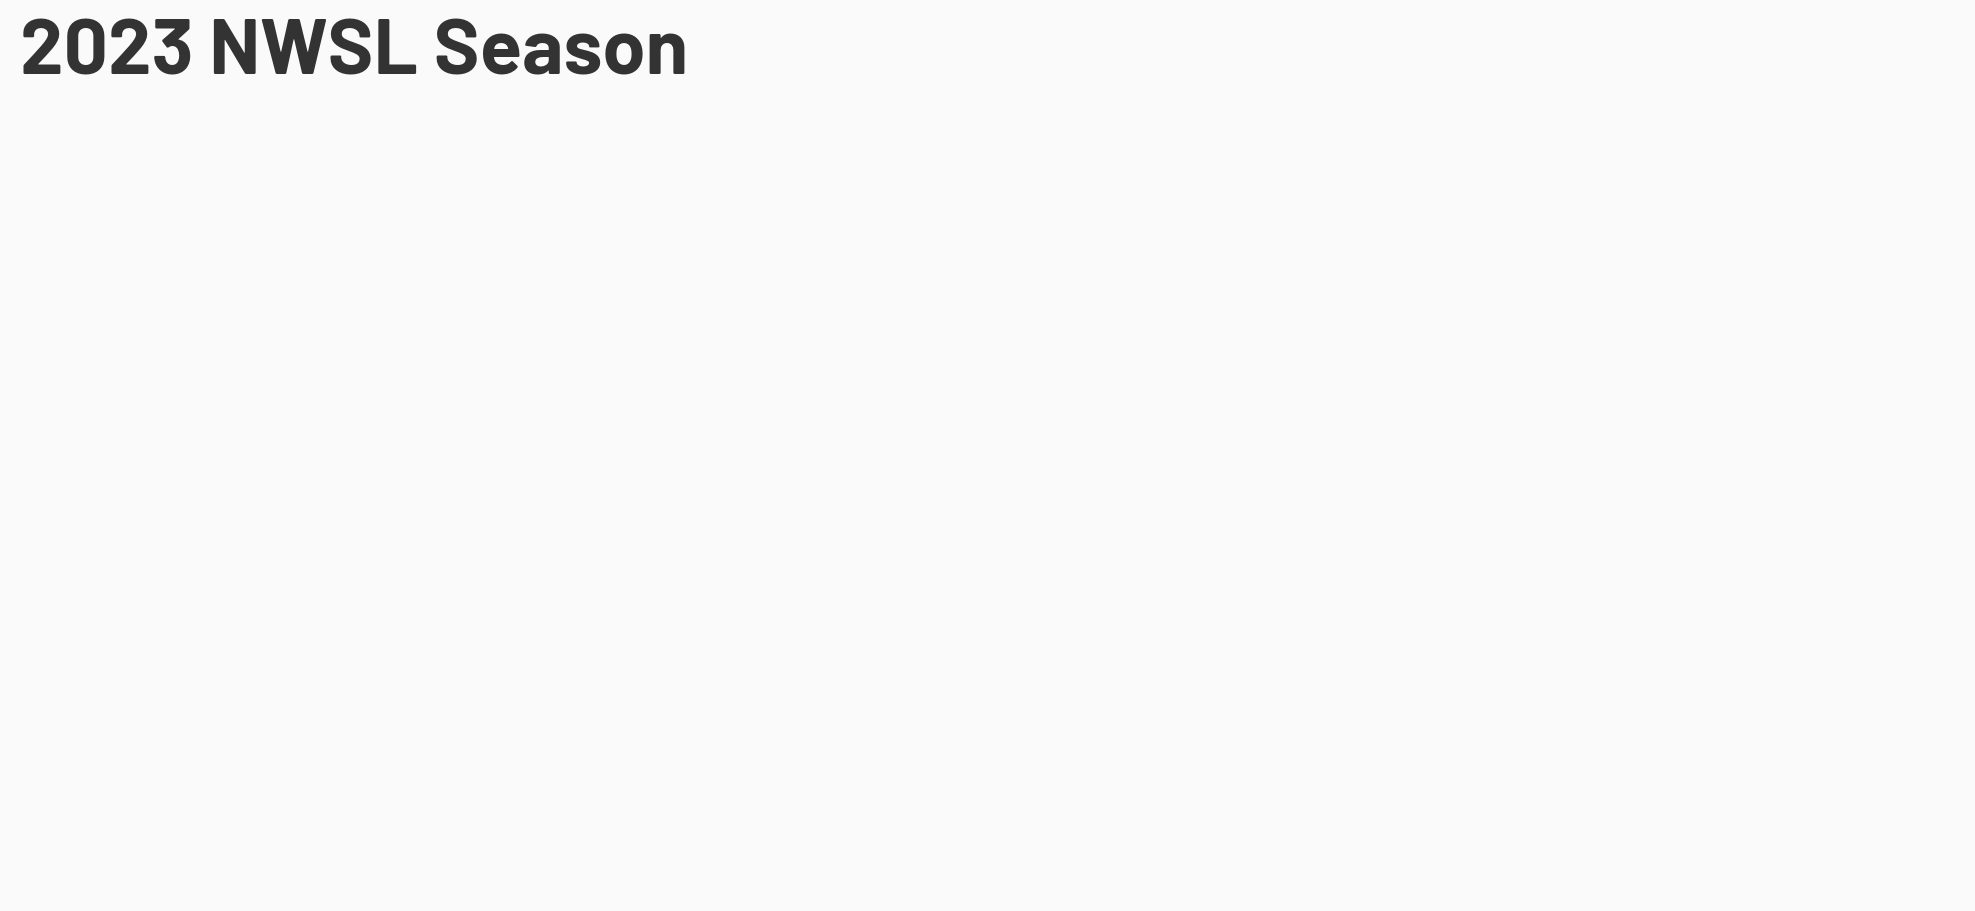

In [7]:
def draw_title(ax):
    ax.text(
        0,
        4 / 3,
        str(year) + " NWSL Season",
        ha="left",
        fontsize=28,
        fontproperties=Fonts.BARLOW_BOLD,
        color=Colors.BLACK,
    )


_, axes = create_axes()
draw_title(axes[3])

<Figure size 432x288 with 0 Axes>

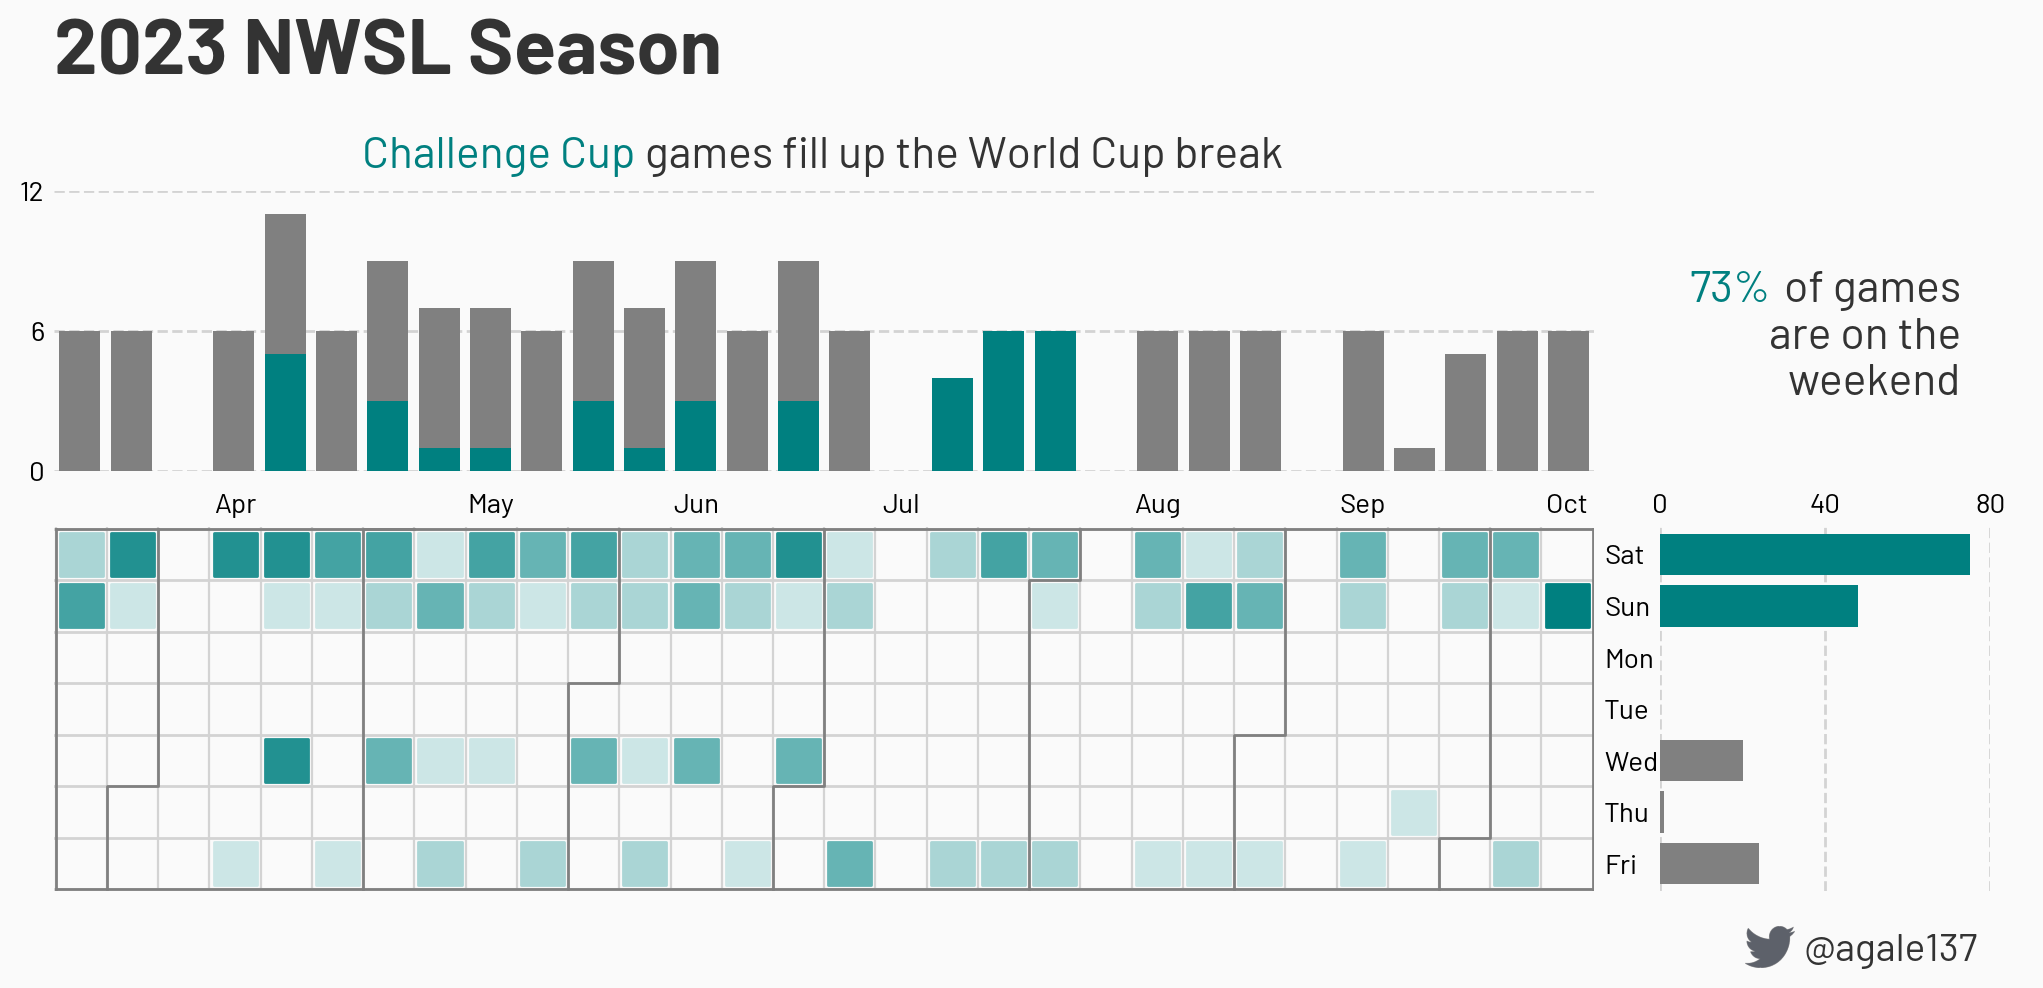

In [8]:
# Put everything together
fig, axes = create_axes()

draw_heatmap(axes[0], axes[1], axes[2])
draw_title(axes[3])

# Twitter logo and username
add_twitter_handle(fig, x=0.765, y=-0.055, fs=14)

plt.savefig(
    "images/" + str(year) + "_season.png",
    bbox_inches="tight",
    transparent=False,
    pad_inches=0.5,
)